In [38]:
# !unzip /content/Faces.zip

In [39]:
# !unzip /content/Background.zip

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D
from skimage import feature, data, color
import os
from tqdm import tqdm
import joblib
from skimage.transform import resize
from sklearn.feature_extraction.image import PatchExtractor
from itertools import chain
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Preparación de los datos

In [41]:
suffix = '.pgm'

all_files = os.listdir('Faces/')
pgm_files = [filename for filename in all_files if filename.endswith(suffix)]

In [42]:
positive_patches = []
for filename in tqdm(pgm_files):
  path = 'Faces/' + filename
  with open(path, 'rb') as pgmf:
      image = plt.imread(pgmf)
  positive_patches.append(image)

100%|██████████| 12833/12833 [00:02<00:00, 4556.75it/s]


In [43]:
positive_patches = np.array(positive_patches)
positive_patches.shape

(12833, 64, 64)

In [44]:
P = len(positive_patches)

In [45]:
# Tomamos algunas imágenes de sklearn
imgs = ['text',
        'coins',
        'moon',
        'page',
        'clock',
        'immunohistochemistry',
        'chelsea',
        'coffee',
        'hubble_deep_field'
        ]

images = []
for name in imgs:
    img = getattr(data, name)()
    if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
        img = color.rgb2gray(img)
        img = (img * 255).astype(np.uint8)
    images.append(resize(img, (100,100)))

# Imagenes caseras adicionales
for i in range(31):
    filename = "Background/"+str(i)+".jpg"
    img = plt.imread(filename)
    img = color.rgb2gray(img)
    images.append(resize(img, (100,100)))

In [46]:
# Tamaño de las imágenes de rostros
size = positive_patches[0].shape
print(f'Image size: {size}')

Image size: (64, 64)


In [47]:
# Función para extraer porciones de una imagen
def extract_patches(img, N, scale=1.0, patch_size=size):
    # Calcula el tamaño del parche extraído basado en el factor de escala dado
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))

    # Inicializa un objeto PatchExtractor con el tamaño de parche calculado,
    # el número máximo de parches, y una semilla de estado aleatorio
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)

    # Extrae parches de la imagen dada
    # img[np.newaxis] se utiliza la entrada de PatchExtractor es un conjunto de imágenes
    patches = extractor.transform(img[np.newaxis])

    # Si el factor de escala no es 1, redimensiona cada parche extraído
    # al tamaño del parche original
    if scale != 1:
        patches = np.array([resize(patch, patch_size) for patch in patches])

    # Devuelve la lista de parches extraídos (y posiblemente redimensionados)
    return patches

In [48]:
# Extraemos las imágenes de fondo
negative_patches = np.vstack([extract_patches(im, 64, scale) for im in tqdm(images, desc='Procesando imágenes') for scale in [0.1,0.25,0.5,0.75,1]])
negative_patches.shape

Procesando imágenes: 100%|██████████| 40/40 [00:00<00:00, 45.71it/s]


(12800, 64, 64)

In [49]:
N = len(negative_patches)

In [50]:
X = np.array([feature.hog(im) for im in tqdm(chain(positive_patches, negative_patches), desc='Construyendo X')])
y = np.zeros(len(X))
y[:P] = 1

Construyendo X: 25633it [00:10, 2375.70it/s]


In [51]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
X_train.shape

(20506, 2916)

In [53]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [54]:
# Guardar el scaler
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [55]:
# Apply PCA to extract eigenfaces

pca = PCA(n_components=500, whiten=True).fit(X_train_std)

In [56]:
# Guardar PCA
joblib.dump(pca, 'pca.joblib')

['pca.joblib']

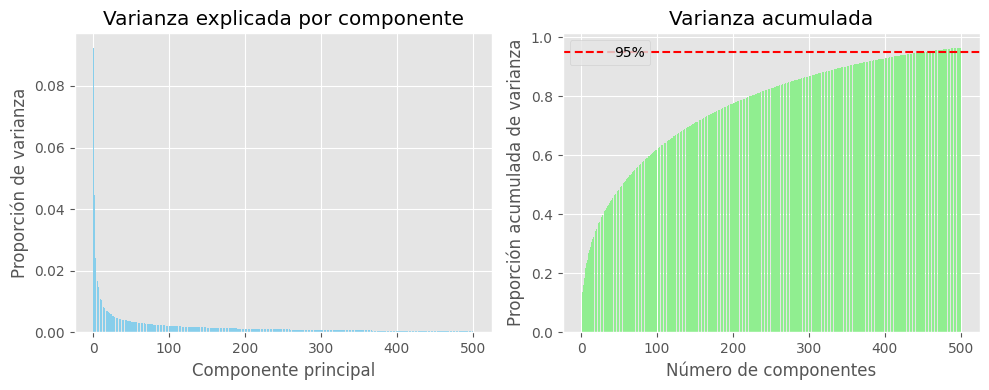

In [57]:
# Obtener varianzas
var_explicada = pca.explained_variance_ratio_
var_acumulada = np.cumsum(var_explicada)

# Gráfico
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Varianza explicada
ax1.bar(range(1, len(var_explicada)+1), var_explicada, color='skyblue')
ax1.set_title('Varianza explicada por componente')
ax1.set_xlabel('Componente principal')
ax1.set_ylabel('Proporción de varianza')
ax1.grid(True)

# Varianza acumulada
ax2.bar(range(1, len(var_acumulada)+1), var_acumulada, color='lightgreen')
ax2.axhline(y=0.95, color='r', linestyle='--', label='95%')
ax2.set_title('Varianza acumulada')
ax2.set_xlabel('Número de componentes')
ax2.set_ylabel('Proporción acumulada de varianza')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

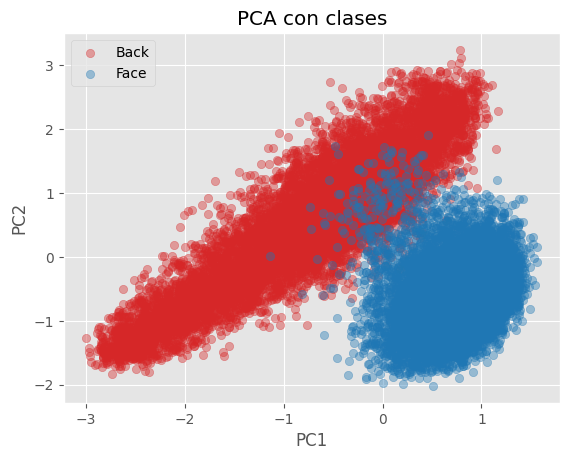

In [58]:
X_train_pca = pca.transform(X_train_std)

# Graficar con colores y leyenda
colors = ['tab:red', 'tab:blue']
labels = ['Back', 'Face']

for class_value in [0, 1]:
    plt.scatter(X_train_pca[y_train == class_value, 0], X_train_pca[y_train == class_value, 1],
                c=colors[class_value], label=labels[class_value], alpha=0.4)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA con clases')
plt.legend()
plt.grid(True)
plt.show()

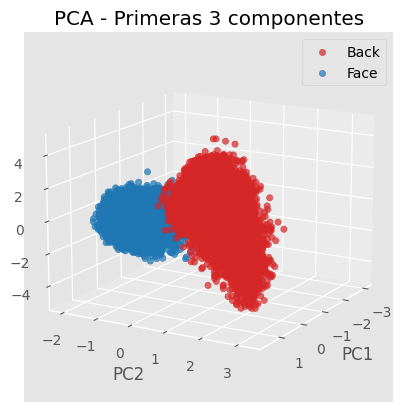

In [59]:
# Plot 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['tab:red', 'tab:blue']
labels = ['Back', 'Face']

for class_value in [0, 1]:
    ax.scatter(
        X_train_pca[y_train == class_value, 0],
        X_train_pca[y_train == class_value, 1],
        X_train_pca[y_train == class_value, 2],
        c=colors[class_value],
        label=labels[class_value],
        alpha=0.7
    )

ax.view_init(elev=15, azim=30)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA - Primeras 3 componentes')
ax.legend()
plt.show()

# Clasificador

In [60]:
model = GaussianNB()

In [61]:
model.fit(X_train_pca, y_train)

GaussianNB()

In [62]:
y_train_pred = model.predict(X_train_pca)

In [63]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93     10273
         1.0       0.92      0.94      0.93     10233

    accuracy                           0.93     20506
   macro avg       0.93      0.93      0.93     20506
weighted avg       0.93      0.93      0.93     20506



In [64]:
X_val_std = scaler.transform(X_val)
X_val_pca = pca.transform(X_val_std)

In [65]:
y_val_pred = model.predict(X_val_pca)

In [66]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94      2527
         1.0       0.93      0.94      0.94      2600

    accuracy                           0.94      5127
   macro avg       0.94      0.94      0.94      5127
weighted avg       0.94      0.94      0.94      5127



In [67]:
# Guardar el modelo
joblib.dump(model, 'modelo_entrenado.joblib')

['modelo_entrenado.joblib']

# Encontrar los mejores hiperparámetros

In [68]:
# pip install optuna

In [69]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [70]:
# Define the objective function for Optuna optimization (GaussianNB only)
def objective(trial):
    # Suggest hyperparameters only for GaussianNB
    var_smoothing = trial.suggest_float('var_smoothing', 1e-12, 1e-6, log=True)
    
    # Use the existing PCA transformation (with original parameters: 500 components, whiten=True)
    # We'll use the already fitted PCA from your original model
    
    # Create and train GaussianNB with suggested parameters
    model_trial = GaussianNB(var_smoothing=var_smoothing)
    
    # Use cross-validation to evaluate the model
    # We use the existing X_train_pca (from your original PCA with 500 components)
    cv_scores = cross_val_score(model_trial, X_train_pca, y_train, 
                               cv=5, scoring='f1', n_jobs=-1)
    
    # Return the mean cross-validation score
    return cv_scores.mean()

In [71]:
# Create a study object and optimize
print("Starting hyperparameter optimization with Optuna...")
study = optuna.create_study(direction='maximize')  # We want to maximize F1-score
study.optimize(objective, n_trials=50)  # You can increase n_trials for better results

print("Optimization completed!")
print(f"Best trial: {study.best_trial.number}")
print(f"Best F1-score: {study.best_value:.4f}")
print("Best parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")


[I 2025-06-22 16:43:32,245] A new study created in memory with name: no-name-18e80d44-09b2-4134-bc9f-2be0f0b9769a


Starting hyperparameter optimization with Optuna...


Python(2888) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(2889) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(2890) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(2891) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(2892) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(2893) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(2894) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(2895) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
[I 2025-06-22 16:43:36,428] Trial 0 finished with value: 0.9310707212000254 and parameters: {'var_smoothing': 1.6969066988589125e-09}. Best is trial 0 with value: 0.9310707212000254.
[I 2025-06-22 16:43:37,595] Trial 1 finis

Optimization completed!
Best trial: 0
Best F1-score: 0.9311
Best parameters:
  var_smoothing: 1.6969066988589125e-09


In [72]:
# Train the final model with the best parameters
best_params = study.best_params

# Use the existing PCA (no optimization needed for PCA)
# We'll use the original pca object that was already fitted
pca_optimized = pca  # Use the original PCA with 500 components and whiten=True
X_train_pca_optimized = X_train_pca  # Use the existing transformation

# Create and train GaussianNB with best parameters
model_optimized = GaussianNB(var_smoothing=best_params['var_smoothing'])
model_optimized.fit(X_train_pca_optimized, y_train)

print("Optimized GaussianNB model trained successfully!")
print(f"Best var_smoothing parameter: {best_params['var_smoothing']}")


Optimized GaussianNB model trained successfully!
Best var_smoothing parameter: 1.6969066988589125e-09


In [73]:
# Evaluate the optimized model on training data
y_train_pred_optimized = model_optimized.predict(X_train_pca_optimized)
print("========== OPTIMIZED MODEL - TRAINING RESULTS ==========")
print(classification_report(y_train, y_train_pred_optimized))


========== OPTIMIZED MODEL - TRAINING RESULTS ==========
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93     10273
         1.0       0.92      0.94      0.93     10233

    accuracy                           0.93     20506
   macro avg       0.93      0.93      0.93     20506
weighted avg       0.93      0.93      0.93     20506



In [74]:
# # Compare original vs optimized model performance
# print("=== PERFORMANCE COMPARISON ===")
# print("\nOriginal Model (Validation):")
# print(f"F1-score: {f1_score(y_val, y_val_pred):.4f}")

# print("\nOptimized Model (Validation):")
# print(f"F1-score: {f1_score(y_val, y_val_pred_optimized):.4f}")

# improvement = f1_score(y_val, y_val_pred_optimized) - f1_score(y_val, y_val_pred)
# print(f"\nImprovement: {improvement:.4f} ({improvement*100:.2f}%)")


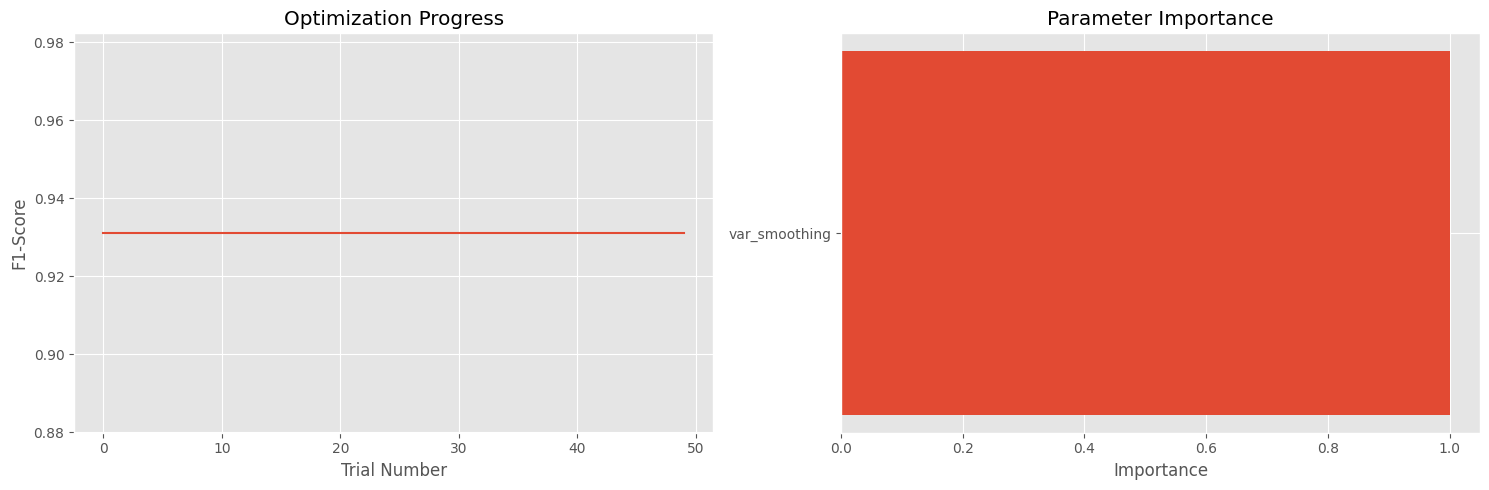

In [75]:
# Visualize optimization history
import matplotlib.pyplot as plt

# Plot optimization history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot objective values over trials
trials_df = study.trials_dataframe()
ax1.plot(trials_df['number'], trials_df['value'])
ax1.set_xlabel('Trial Number')
ax1.set_ylabel('F1-Score')
ax1.set_title('Optimization Progress')
ax1.grid(True)

# Plot parameter importance (if available)
try:
    importance = optuna.importance.get_param_importances(study)
    params = list(importance.keys())
    values = list(importance.values())
    
    ax2.barh(params, values)
    ax2.set_xlabel('Importance')
    ax2.set_title('Parameter Importance')
    ax2.grid(True)
except:
    ax2.text(0.5, 0.5, 'Parameter importance\nnot available', 
             ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Parameter Importance')

plt.tight_layout()
plt.show()


In [76]:
# Save the optimized GaussianNB model
# Note: PCA remains the same as original (500 components, whiten=True)
joblib.dump(model_optimized, 'modelo_gaussianNB_optimizado.joblib')

print("Optimized GaussianNB model saved successfully!")
print(f"- GaussianNB optimized: modelo_gaussianNB_optimizado.joblib")
print(f"- PCA (unchanged): pca.joblib")
print(f"- Scaler (unchanged): scaler.joblib")


Optimized GaussianNB model saved successfully!
- GaussianNB optimized: modelo_gaussianNB_optimizado.joblib
- PCA (unchanged): pca.joblib
- Scaler (unchanged): scaler.joblib


In [77]:
# Evaluate the optimized model on validation data
X_val_pca_optimized = X_val_pca  # Use the existing validation PCA transformation
y_val_pred_optimized = model_optimized.predict(X_val_pca_optimized)

print("=== OPTIMIZED MODEL - VALIDATION RESULTS ===")
print(classification_report(y_val, y_val_pred_optimized))
y_val_pred_optimized = model_optimized.predict(X_val_pca_optimized)

print("=== OPTIMIZED MODEL - VALIDATION RESULTS ===")
print(classification_report(y_val, y_val_pred_optimized))


=== OPTIMIZED MODEL - VALIDATION RESULTS ===
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94      2527
         1.0       0.93      0.94      0.94      2600

    accuracy                           0.94      5127
   macro avg       0.94      0.94      0.94      5127
weighted avg       0.94      0.94      0.94      5127

=== OPTIMIZED MODEL - VALIDATION RESULTS ===
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94      2527
         1.0       0.93      0.94      0.94      2600

    accuracy                           0.94      5127
   macro avg       0.94      0.94      0.94      5127
weighted avg       0.94      0.94      0.94      5127



In [78]:
# Define the objective function for Optuna optimization
def objective(trial):
    # Suggest hyperparameters
    n_components = trial.suggest_int('n_components', 50, 1000, step=50)
    whiten = trial.suggest_categorical('whiten', [True, False])
    var_smoothing = trial.suggest_float('var_smoothing', 1e-12, 1e-6, log=True)
    
    # Apply PCA with suggested parameters
    pca_trial = PCA(n_components=n_components, whiten=whiten)
    X_train_pca_trial = pca_trial.fit_transform(X_train_std)
    
    # Create and train GaussianNB with suggested parameters
    model_trial = GaussianNB(var_smoothing=var_smoothing)
    
    # Use cross-validation to evaluate the model
    # We use f1_score as the metric since it's good for binary classification
    cv_scores = cross_val_score(model_trial, X_train_pca_trial, y_train, 
                               cv=5, scoring='f1', n_jobs=-1)
    
    # Return the mean cross-validation score
    return cv_scores.mean()


#######

In [79]:
# Define the objective function for Optuna optimization
def objective(trial):
    # Hyperparameters to optimize
    n_positive_samples = trial.suggest_int('n_positive_samples', 2000, len(positive_patches), step=1000)
    var_smoothing = trial.suggest_float('var_smoothing', 1e-12, 1e-6, log=True)

    # --- Data Preparation inside the objective ---
    # Select a subset of positive patches
    current_positive_patches = positive_patches[:n_positive_samples]

    # Combine positive and negative patches to form the full dataset
    X_full = np.array([feature.hog(im) for im in chain(current_positive_patches, negative_patches)])
    y_full = np.zeros(len(X_full))
    y_full[:len(current_positive_patches)] = 1

    # Split data into training and validation sets
    X_train_trial, X_val_trial, y_train_trial, y_val_trial = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

    # Scale the features
    scaler_trial = StandardScaler()
    X_train_std_trial = scaler_trial.fit_transform(X_train_trial)

    # Apply PCA (fixed parameters as per previous discussion, n_components=500, whiten=True)
    pca_trial = PCA(n_components=500, whiten=True)
    X_train_pca_trial = pca_trial.fit_transform(X_train_std_trial)
    # --- End Data Preparation ---

    # Create and train GaussianNB with suggested parameters
    model_trial = GaussianNB(var_smoothing=var_smoothing)

    # Use cross-validation to evaluate the model
    cv_scores = cross_val_score(model_trial, X_train_pca_trial, y_train_trial,
                                cv=5, scoring='f1', n_jobs=-1)

    # Return the mean cross-validation score
    return cv_scores.mean()

In [80]:
# Create a study object and optimize
print("Starting hyperparameter optimization with Optuna...")
# We want to maximize the F1-score, so direction='maximize'
study = optuna.create_study(direction='maximize')
# Run the optimization for 50 trials (you can increase this for potentially better results)
study.optimize(objective, n_trials=50, show_progress_bar=True) # show_progress_bar=True added for visual progress

print("\nOptimization completed!")
print(f"Best trial number: {study.best_trial.number}")
print(f"Best F1-score: {study.best_value:.4f}")
print("Best parameters found:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-06-22 16:43:53,050] A new study created in memory with name: no-name-3e19fbaf-74fe-4459-aa00-6f3a117675f0


Starting hyperparameter optimization with Optuna...


  0%|          | 0/50 [00:00<?, ?it/s]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(
Best trial: 0. Best value: 0.929757:   2%|▏         | 1/50 [00:16<13:04, 16.01s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:44:09,062] Trial 0 finished with value: 0.9297574605239705 and parameters: {'n_positive_samples': 8000, 'var_smoothing': 3.382547857295605e-09}. Best is trial 0 with value: 0.9297574605239705.


Best trial: 0. Best value: 0.929757:   4%|▍         | 2/50 [00:27<10:42, 13.38s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:44:20,606] Trial 1 finished with value: 0.8958178381059666 and parameters: {'n_positive_samples': 4000, 'var_smoothing': 1.3016936779653399e-12}. Best is trial 0 with value: 0.9297574605239705.


Best trial: 0. Best value: 0.929757:   6%|▌         | 3/50 [00:38<09:46, 12.49s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:44:32,027] Trial 2 finished with value: 0.8948223982502419 and parameters: {'n_positive_samples': 4000, 'var_smoothing': 8.236616752150467e-08}. Best is trial 0 with value: 0.9297574605239705.


Best trial: 0. Best value: 0.929757:   8%|▊         | 4/50 [00:49<08:50, 11.54s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:44:42,118] Trial 3 finished with value: 0.8925213067654785 and parameters: {'n_positive_samples': 3000, 'var_smoothing': 8.949562457447403e-10}. Best is trial 0 with value: 0.9297574605239705.


Best trial: 0. Best value: 0.929757:  10%|█         | 5/50 [00:58<08:03, 10.74s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:44:51,428] Trial 4 finished with value: 0.8949680141254228 and parameters: {'n_positive_samples': 2000, 'var_smoothing': 4.2600728673312426e-12}. Best is trial 0 with value: 0.9297574605239705.


Best trial: 0. Best value: 0.929757:  12%|█▏        | 6/50 [01:09<07:58, 10.88s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:45:02,598] Trial 5 finished with value: 0.8942885367472113 and parameters: {'n_positive_samples': 4000, 'var_smoothing': 4.271495867313466e-12}. Best is trial 0 with value: 0.9297574605239705.


Best trial: 6. Best value: 0.93803:  14%|█▍        | 7/50 [01:25<08:56, 12.48s/it] /Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:45:18,350] Trial 6 finished with value: 0.938030009333447 and parameters: {'n_positive_samples': 12000, 'var_smoothing': 4.091274906126516e-07}. Best is trial 6 with value: 0.938030009333447.


Best trial: 6. Best value: 0.93803:  16%|█▌        | 8/50 [01:37<08:35, 12.27s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:45:30,180] Trial 7 finished with value: 0.9024523427592275 and parameters: {'n_positive_samples': 6000, 'var_smoothing': 9.177180324117256e-10}. Best is trial 6 with value: 0.938030009333447.


Best trial: 6. Best value: 0.93803:  18%|█▊        | 9/50 [01:46<07:52, 11.52s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:45:40,037] Trial 8 finished with value: 0.892564262986394 and parameters: {'n_positive_samples': 3000, 'var_smoothing': 1.5189669666590648e-07}. Best is trial 6 with value: 0.938030009333447.


Best trial: 6. Best value: 0.93803:  20%|██        | 10/50 [02:00<08:00, 12.01s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:45:53,159] Trial 9 finished with value: 0.9287151617303502 and parameters: {'n_positive_samples': 8000, 'var_smoothing': 4.705198964921875e-09}. Best is trial 6 with value: 0.938030009333447.


Best trial: 6. Best value: 0.93803:  22%|██▏       | 11/50 [02:16<08:35, 13.21s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:46:09,083] Trial 10 finished with value: 0.9374667758469908 and parameters: {'n_positive_samples': 12000, 'var_smoothing': 7.60469076691461e-07}. Best is trial 6 with value: 0.938030009333447.


Best trial: 6. Best value: 0.93803:  24%|██▍       | 12/50 [02:31<08:53, 14.04s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:46:25,019] Trial 11 finished with value: 0.9377994449806624 and parameters: {'n_positive_samples': 12000, 'var_smoothing': 7.760090341537166e-07}. Best is trial 6 with value: 0.938030009333447.


Best trial: 6. Best value: 0.93803:  26%|██▌       | 13/50 [02:47<08:57, 14.53s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:46:40,677] Trial 12 finished with value: 0.9372597264030166 and parameters: {'n_positive_samples': 12000, 'var_smoothing': 8.682079273466091e-07}. Best is trial 6 with value: 0.938030009333447.


Best trial: 6. Best value: 0.93803:  28%|██▊       | 14/50 [03:01<08:38, 14.42s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:46:54,829] Trial 13 finished with value: 0.9364324648246878 and parameters: {'n_positive_samples': 10000, 'var_smoothing': 3.792862926329783e-08}. Best is trial 6 with value: 0.938030009333447.


Best trial: 6. Best value: 0.93803:  30%|███       | 15/50 [03:16<08:24, 14.41s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:47:09,220] Trial 14 finished with value: 0.9370204996862042 and parameters: {'n_positive_samples': 10000, 'var_smoothing': 9.581738852555841e-11}. Best is trial 6 with value: 0.938030009333447.


Best trial: 6. Best value: 0.93803:  32%|███▏      | 16/50 [03:30<08:09, 14.40s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:47:23,598] Trial 15 finished with value: 0.9359862547589224 and parameters: {'n_positive_samples': 10000, 'var_smoothing': 1.6324465036005647e-08}. Best is trial 6 with value: 0.938030009333447.


Best trial: 6. Best value: 0.93803:  34%|███▍      | 17/50 [03:44<07:52, 14.33s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:47:37,765] Trial 16 finished with value: 0.937943014547232 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 2.3514883875478344e-07}. Best is trial 6 with value: 0.938030009333447.


Best trial: 17. Best value: 0.93804:  36%|███▌      | 18/50 [04:00<07:52, 14.76s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:47:53,535] Trial 17 finished with value: 0.9380403335418436 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 1.4987042794128355e-10}. Best is trial 17 with value: 0.9380403335418436.


Best trial: 17. Best value: 0.93804:  38%|███▊      | 19/50 [04:14<07:34, 14.66s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:48:07,952] Trial 18 finished with value: 0.9289186770760913 and parameters: {'n_positive_samples': 8000, 'var_smoothing': 1.168714741309263e-10}. Best is trial 17 with value: 0.9380403335418436.


Best trial: 17. Best value: 0.93804:  40%|████      | 20/50 [04:27<06:57, 13.90s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:48:20,099] Trial 19 finished with value: 0.902320472652109 and parameters: {'n_positive_samples': 6000, 'var_smoothing': 1.3955682414252915e-10}. Best is trial 17 with value: 0.9380403335418436.


Best trial: 17. Best value: 0.93804:  42%|████▏     | 21/50 [04:41<06:50, 14.15s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:48:34,823] Trial 20 finished with value: 0.9187945972001316 and parameters: {'n_positive_samples': 9000, 'var_smoothing': 1.2514872101755562e-11}. Best is trial 17 with value: 0.9380403335418436.


Best trial: 17. Best value: 0.93804:  44%|████▍     | 22/50 [04:57<06:47, 14.57s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:48:50,365] Trial 21 finished with value: 0.9379848361341262 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 1.755919846346037e-07}. Best is trial 17 with value: 0.9380403335418436.


Best trial: 22. Best value: 0.938399:  46%|████▌     | 23/50 [05:12<06:37, 14.71s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:49:05,408] Trial 22 finished with value: 0.9383993646049016 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 8.999845517933542e-09}. Best is trial 22 with value: 0.9383993646049016.


Best trial: 22. Best value: 0.938399:  48%|████▊     | 24/50 [05:27<06:27, 14.92s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:49:20,806] Trial 23 finished with value: 0.9379671552868591 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 7.115113741203899e-09}. Best is trial 22 with value: 0.9383993646049016.


Best trial: 22. Best value: 0.938399:  50%|█████     | 25/50 [05:43<06:15, 15.03s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:49:36,112] Trial 24 finished with value: 0.938012366357925 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 3.1302667061666734e-10}. Best is trial 22 with value: 0.9383993646049016.


Best trial: 22. Best value: 0.938399:  52%|█████▏    | 26/50 [05:57<05:54, 14.79s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:49:50,330] Trial 25 finished with value: 0.9186163135154379 and parameters: {'n_positive_samples': 9000, 'var_smoothing': 4.5136440135229314e-11}. Best is trial 22 with value: 0.9383993646049016.


Best trial: 22. Best value: 0.938399:  54%|█████▍    | 27/50 [06:13<05:50, 15.22s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:50:06,556] Trial 26 finished with value: 0.9380573315590857 and parameters: {'n_positive_samples': 12000, 'var_smoothing': 2.4145942797919014e-08}. Best is trial 22 with value: 0.9383993646049016.


Best trial: 22. Best value: 0.938399:  56%|█████▌    | 28/50 [06:27<05:29, 14.97s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:50:20,946] Trial 27 finished with value: 0.9177816259268694 and parameters: {'n_positive_samples': 9000, 'var_smoothing': 1.8638000839086836e-08}. Best is trial 22 with value: 0.9383993646049016.


Best trial: 22. Best value: 0.938399:  58%|█████▊    | 29/50 [06:42<05:12, 14.87s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:50:35,588] Trial 28 finished with value: 0.9366235826385318 and parameters: {'n_positive_samples': 10000, 'var_smoothing': 2.1472599212253154e-09}. Best is trial 22 with value: 0.9383993646049016.


Best trial: 22. Best value: 0.938399:  60%|██████    | 30/50 [06:55<04:44, 14.23s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:50:48,311] Trial 29 finished with value: 0.9167417683688764 and parameters: {'n_positive_samples': 7000, 'var_smoothing': 2.2623718589203472e-09}. Best is trial 22 with value: 0.9383993646049016.


Best trial: 22. Best value: 0.938399:  62%|██████▏   | 31/50 [07:11<04:43, 14.94s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:51:04,920] Trial 30 finished with value: 0.9383887924668297 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 3.551401312081216e-10}. Best is trial 22 with value: 0.9383993646049016.


Best trial: 31. Best value: 0.938869:  64%|██████▍   | 32/50 [07:27<04:31, 15.09s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:51:20,362] Trial 31 finished with value: 0.9388692822546341 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 4.300079567495854e-10}. Best is trial 31 with value: 0.9388692822546341.


Best trial: 31. Best value: 0.938869:  66%|██████▌   | 33/50 [07:43<04:20, 15.34s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:51:36,285] Trial 32 finished with value: 0.9375865584907453 and parameters: {'n_positive_samples': 12000, 'var_smoothing': 5.532302153040833e-10}. Best is trial 31 with value: 0.9388692822546341.


Best trial: 31. Best value: 0.938869:  68%|██████▊   | 34/50 [07:59<04:11, 15.70s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:51:52,821] Trial 33 finished with value: 0.9377129119124998 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 9.73965535005136e-09}. Best is trial 31 with value: 0.9388692822546341.


Best trial: 31. Best value: 0.938869:  70%|███████   | 35/50 [08:15<03:57, 15.82s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:52:08,936] Trial 34 finished with value: 0.9362461810917566 and parameters: {'n_positive_samples': 10000, 'var_smoothing': 5.832210719154745e-08}. Best is trial 31 with value: 0.9388692822546341.


Best trial: 31. Best value: 0.938869:  72%|███████▏  | 36/50 [08:32<03:44, 16.02s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:52:25,421] Trial 35 finished with value: 0.9378749922351748 and parameters: {'n_positive_samples': 12000, 'var_smoothing': 2.062830112443245e-09}. Best is trial 31 with value: 0.9388692822546341.


Best trial: 31. Best value: 0.938869:  74%|███████▍  | 37/50 [08:46<03:19, 15.37s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:52:39,266] Trial 36 finished with value: 0.9185035632850355 and parameters: {'n_positive_samples': 9000, 'var_smoothing': 3.228680981221638e-11}. Best is trial 31 with value: 0.9388692822546341.


Best trial: 31. Best value: 0.938869:  76%|███████▌  | 38/50 [09:00<02:59, 14.93s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:52:53,161] Trial 37 finished with value: 0.9293578431172411 and parameters: {'n_positive_samples': 8000, 'var_smoothing': 3.31278808455573e-10}. Best is trial 31 with value: 0.9388692822546341.


Best trial: 31. Best value: 0.938869:  78%|███████▊  | 39/50 [09:15<02:47, 15.21s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:53:09,045] Trial 38 finished with value: 0.9382580759625192 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 2.60384422009603e-08}. Best is trial 31 with value: 0.9388692822546341.


Best trial: 31. Best value: 0.938869:  80%|████████  | 40/50 [09:30<02:31, 15.12s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:53:23,949] Trial 39 finished with value: 0.9358270178541588 and parameters: {'n_positive_samples': 10000, 'var_smoothing': 1.066658212417255e-09}. Best is trial 31 with value: 0.9388692822546341.


Best trial: 31. Best value: 0.938869:  82%|████████▏ | 41/50 [09:42<02:05, 13.98s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:53:35,274] Trial 40 finished with value: 0.9009525070259322 and parameters: {'n_positive_samples': 5000, 'var_smoothing': 4.526452696596445e-09}. Best is trial 31 with value: 0.9388692822546341.


Best trial: 31. Best value: 0.938869:  84%|████████▍ | 42/50 [09:56<01:53, 14.17s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:53:49,870] Trial 41 finished with value: 0.9386712126355027 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 3.3113519896639204e-08}. Best is trial 31 with value: 0.9388692822546341.


Best trial: 31. Best value: 0.938869:  86%|████████▌ | 43/50 [10:12<01:41, 14.56s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:54:05,357] Trial 42 finished with value: 0.9387665434156016 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 8.671775672816078e-08}. Best is trial 31 with value: 0.9388692822546341.


Best trial: 31. Best value: 0.938869:  88%|████████▊ | 44/50 [10:27<01:28, 14.73s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:54:20,493] Trial 43 finished with value: 0.9376590774430447 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 1.0774736970543225e-07}. Best is trial 31 with value: 0.9388692822546341.


Best trial: 31. Best value: 0.938869:  90%|█████████ | 45/50 [10:42<01:13, 14.77s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:54:35,329] Trial 44 finished with value: 0.9362417749763914 and parameters: {'n_positive_samples': 10000, 'var_smoothing': 5.5659358503477056e-08}. Best is trial 31 with value: 0.9388692822546341.


Best trial: 31. Best value: 0.938869:  92%|█████████▏| 46/50 [10:57<01:00, 15.05s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:54:51,040] Trial 45 finished with value: 0.937863480069862 and parameters: {'n_positive_samples': 12000, 'var_smoothing': 1.2081924888993703e-08}. Best is trial 31 with value: 0.9388692822546341.


Best trial: 31. Best value: 0.938869:  94%|█████████▍| 47/50 [11:08<00:40, 13.59s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:55:01,236] Trial 46 finished with value: 0.894034784616118 and parameters: {'n_positive_samples': 2000, 'var_smoothing': 2.868861487989406e-07}. Best is trial 31 with value: 0.9388692822546341.


Best trial: 31. Best value: 0.938869:  96%|█████████▌| 48/50 [11:23<00:27, 13.99s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:55:16,143] Trial 47 finished with value: 0.9385725441268689 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 7.657060523095437e-10}. Best is trial 31 with value: 0.9388692822546341.


Best trial: 31. Best value: 0.938869:  98%|█████████▊| 49/50 [11:36<00:13, 13.93s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 16:55:29,946] Trial 48 finished with value: 0.9182529964462736 and parameters: {'n_positive_samples': 9000, 'var_smoothing': 9.88248500021702e-10}. Best is trial 31 with value: 0.9388692822546341.


Best trial: 31. Best value: 0.938869: 100%|██████████| 50/50 [11:51<00:00, 14.23s/it]

[I 2025-06-22 16:55:44,536] Trial 49 finished with value: 0.9365825570191226 and parameters: {'n_positive_samples': 10000, 'var_smoothing': 9.145643989431664e-08}. Best is trial 31 with value: 0.9388692822546341.

Optimization completed!
Best trial number: 31
Best F1-score: 0.9389
Best parameters found:
  n_positive_samples: 11000
  var_smoothing: 4.300079567495854e-10


In [81]:
study.best_params

{'n_positive_samples': 11000, 'var_smoothing': 4.300079567495854e-10}

In [82]:
# Train the final model with the best parameters
best_params = study.best_params

# Re-prepare the data using the best n_positive_samples
final_n_positive_samples = best_params['n_positive_samples']
final_current_positive_patches = positive_patches[:final_n_positive_samples]

# Combine positive and negative patches to form the full dataset
X_final_full = np.array([feature.hog(im) for im in chain(final_current_positive_patches, negative_patches)])
y_final_full = np.zeros(len(X_final_full))
y_final_full[:len(final_current_positive_patches)] = 1

# Split data into training and validation sets
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X_final_full, y_final_full, test_size=0.2, random_state=42)

# Scale the features
scaler_final = StandardScaler()
X_train_std_final = scaler_final.fit_transform(X_train_final)
X_val_std_final = scaler_final.transform(X_val_final) # Scale validation data too

# Apply PCA (fixed parameters: 500 components, whiten=True)
pca_final = PCA(n_components=500, whiten=True)
X_train_pca_final = pca_final.fit_transform(X_train_std_final)
X_val_pca_final = pca_final.transform(X_val_std_final) # Transform validation data

# Create and train GaussianNB with best parameters
model_optimized = GaussianNB(var_smoothing=best_params['var_smoothing'])
model_optimized.fit(X_train_pca_final, y_train_final)

print("Optimized GaussianNB model trained successfully with best parameters!")
print(f"Best n_positive_samples: {best_params['n_positive_samples']}")
print(f"Best var_smoothing parameter: {best_params['var_smoothing']}")

Optimized GaussianNB model trained successfully with best parameters!
Best n_positive_samples: 11000
Best var_smoothing parameter: 4.300079567495854e-10


In [83]:
os.getcwd()

'/Users/rodrigobenitez/Documents/GitHub/ORT-AI/ML para AI/Obligatorio'

In [84]:
joblib.dump(scaler_final ,'models/scaler_optuna.joblib')

['models/scaler_optuna.joblib']

In [85]:
joblib.dump(pca_final ,'models/pca_optuna.joblib')

['models/pca_optuna.joblib']

In [86]:
joblib.dump(model_optimized ,'models/GaussianNB_optuna.joblib')

['models/GaussianNB_optuna.joblib']